In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from acquire import get_telco_data
from prepare import chop_data,prep_telco,keep_cust_prep_telco,charts_telco
from Exo import churners, gender_impact,senior_citizen_churn, security_impact
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier,export_text, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import KNeighborsClassifier

import warnings

warnings.filterwarnings('ignore')

this file exists, reading csv


In [2]:
base = prep_telco(get_telco_data)

In [3]:
trained_telco,validated_telco,tested_telco = chop_data(base,"churn")

In [5]:
trained_telco.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,security_backup,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
2865,1,1,1,0,38,1,1,0,95.00,3591.25,0,1,1,0,1,0,0,1,0,0
4107,1,1,0,0,2,1,0,1,70.35,139.05,1,1,0,1,0,0,0,0,1,0
3453,0,1,1,0,11,1,0,0,19.95,214.75,1,0,0,1,0,0,0,0,0,1
923,0,0,0,0,10,1,1,1,86.05,834.10,1,1,0,1,0,0,1,0,0,0
2370,0,0,0,0,43,1,0,1,60.00,2548.55,0,1,1,0,0,1,0,0,1,0


alpha =0.05


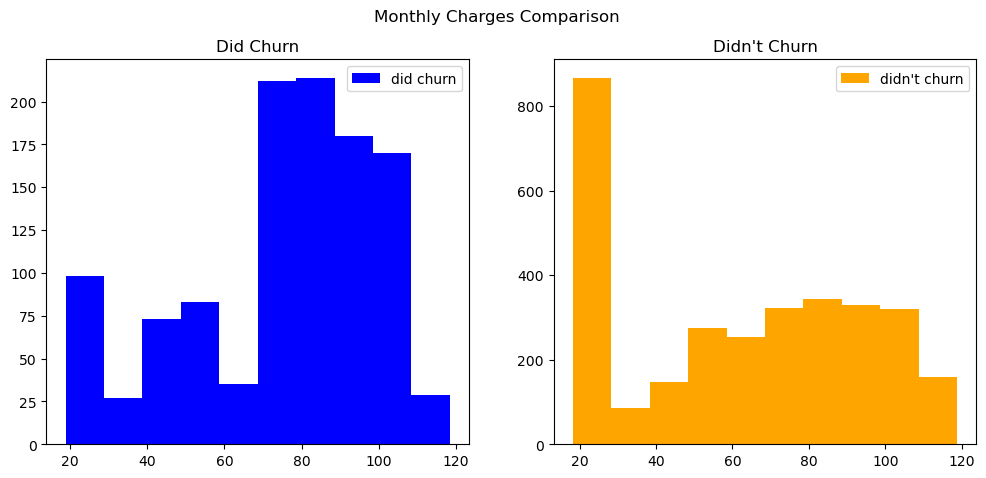

In [6]:
churners(trained_telco)

In [8]:
charges__churn_rate = pd.crosstab(columns=trained_telco.monthly_charges,index=trained_telco.churn)

In [9]:
charges__churn_rate

monthly_charges,18.25,18.40,18.55,18.70,18.75,18.80,18.85,18.90,18.95,19.00,...,116.75,116.85,116.95,117.45,117.50,118.20,118.35,118.60,118.65,118.75
churn,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,2,2,1,3,5,...,1,1,1,0,1,1,0,1,1,1
1,0,0,0,0,0,0,1,0,1,1,...,0,0,0,1,0,0,1,0,0,0


In [ ]:
chi2, charges_pval, degf, expected = stats.chi2_contingency(charges__churn_rate) #Mannwhitney

In [ ]:
charges_pval

alpha =0.05

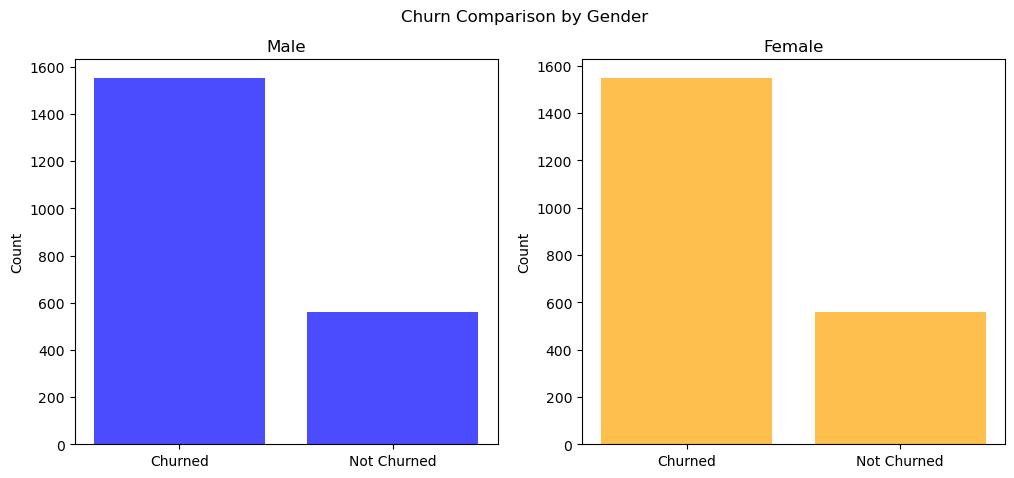

In [10]:
gender_impact(trained_telco)

In [11]:
gender__churn_rate = pd.crosstab(columns=trained_telco.gender,index=trained_telco.churn)

In [12]:
gender__churn_rate

gender,0,1
churn,,
0,1554,1550
1,562,559


In [13]:
chi2, gender_pval, degf, expected = stats.chi2_contingency(gender__churn_rate)

In [14]:
gender_pval

0.996031931504371

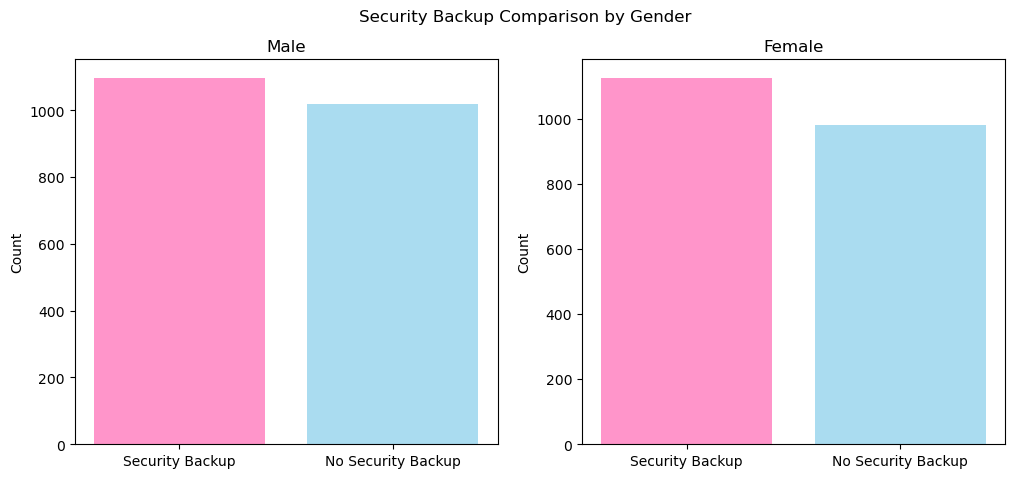

In [32]:
security_impact(trained_telco)

In [34]:
security_purchase_rate = pd.crosstab(columns=trained_telco.security_backup,index=trained_telco.gender)

In [35]:
security_purchase_rate 

security_backup,0,1
gender,,
0,1098,1018
1,1128,981


In [36]:
chi2, security_pval, degf, expected = stats.chi2_contingency(security_purchase_rate)

In [37]:
security_pval

0.3138183526114294

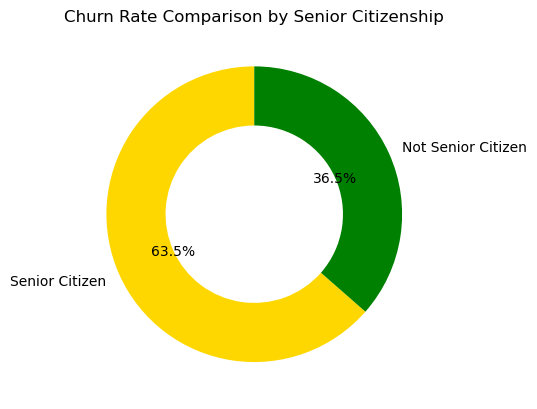

In [26]:
senior_citizen_churn(trained_telco)

alpha =0.05

In [27]:
senior_churn_rate = pd.crosstab(columns=trained_telco.monthly_charges,index=trained_telco.senior_citizen)

In [28]:
senior_churn_rate

monthly_charges,18.25,18.40,18.55,18.70,18.75,18.80,18.85,18.90,18.95,19.00,...,116.75,116.85,116.95,117.45,117.50,118.20,118.35,118.60,118.65,118.75
senior_citizen,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,2,3,1,4,6,...,0,1,1,0,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [29]:
chi2, senior_pval, degf, expected = stats.chi2_contingency(senior_churn_rate)

In [30]:
senior_pval

7.328201978139171e-09

alpha =0.05

<span style="font-size: 16pt;">Modeling</span>

In [52]:
classy = DecisionTreeClassifier()

In [70]:
X_train = trained_telco.drop(columns="churn") #Create X_train variables that drop the survive target
X_validate = validated_telco.drop(columns='churn')
X_test = tested_telco.drop(columns='churn')

In [71]:
y_train = trained_telco.churn #Create y target variables
y_validate = validated_telco.churn
y_test = tested_telco.churn

In [72]:
y_train.value_counts(normalize=True)[0] #BASELINE ACCURACY CHURN

0.7346745562130178

In [73]:
# did_churn = trained_telco[trained_telco.churn == 1]
# didnt_churn= trained_telco[trained_telco.churn == 0]
# did_churn.monthly_charges.var()

In [74]:
classy.fit(X_train,y_train)

DecisionTreeClassifier()

In [75]:
y_predictor = classy.predict(X_train)

In [76]:
y_predictor[:10]

array([0, 1, 1, 1, 0, 0, 1, 0, 0, 1])

In [77]:
classy.score(X_test,y_test)

0.7331440738112136

In [78]:
y_train.value_counts(normalize=True)[0] #BASELINE ACCURACY CHURN

0.7346745562130178

In [79]:
y_train4 = trained_telco.churn #Create y target variables
y_validate4 = validated_telco.churn
y_test4 = tested_telco.churn

In [80]:
classy4 = DecisionTreeClassifier(max_depth=4)

In [81]:
classy10 =DecisionTreeClassifier(max_depth=10)

In [58]:
classy20 =DecisionTreeClassifier(max_depth=20)

In [59]:
classy4.fit(X_train4,y_train4)
classy10.fit(X_train4,y_train4)
classy20.fit(X_train4,y_train4)

DecisionTreeClassifier(max_depth=20)

In [60]:
classy4.score(X_train4,y_train4)

0.7346745562130178

In [61]:
classy10.score(X_train4,y_train4)

0.7346745562130178

In [62]:
classy20.score(X_train4,y_train4)

0.7346745562130178

In [82]:
X_train3 = trained_telco.drop(columns="senior_citizen") 

In [64]:
y_train3 = trained_telco.senior_citizen

In [65]:
y_train3.value_counts(normalize=True)[0] #Accuracy score

0.8357396449704142

In [66]:
classy8=DecisionTreeClassifier(max_depth=8)

In [67]:
classy8.fit(X_train3,y_train3)

DecisionTreeClassifier(max_depth=8)

In [43]:
classy8.score(X_train3,y_train3)

0.8622485207100592